In [1]:
# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit=True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
import pandas as pd

TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1
1,1392518336,0
2,361208576,1
3,1535215357,1
4,4396196375,1


In [3]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    try:
        tweets = api.GetUserTimeline(user_id, count = 200, trim_user=True, exclude_replies=True)
#        tweets = [tweet for tweet in tweets ]
    except:
        return []
    tweets = [tweet.AsDict() for tweet in tweets]
    return tweets

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
import unicodedata
import sys
import re
import nltk
# nltk.download()

def get_words(text):
    """returns list of words"""
    # your code here
    # exclude url from the text
    without_url = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)*\/?', '', text)
    # exclude punctuation
    without_punct = re.findall(r'[a-z]+', without_url.lower())
    
    return without_punct

In [5]:
print get_words(u"wer dfgh 1fdfg 234ghj 24234,https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml")

[u'wer', u'dfgh', u'fdfg', u'ghj']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
def get_tokens(words):
    """returns list of tokens"""
    # your code here
    lemmas = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    return lemmas

In [7]:
print get_tokens([u"here", u"are", u"different", u"words"])

[u'different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [6]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [7]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # your code here
    users_list = list(df_users['uid'].values)
    valid_users_list = []
    list_of_dicts = []
    for uid in users_list:
        dict_of_tokens = {}
        tweets = get_user_tweets(uid)
        if tweets == []:
            continue
        for tweet in tweets:
            for token in get_tweet_tokens(tweet[u'text']):
                if token not in dict_of_tokens:
                    dict_of_tokens[token] = 1
                else:
                    dict_of_tokens[token] += 1
        valid_users_list.append(uid)
        list_of_dicts.append(dict_of_tokens)
            
                
    # save intermediate result
    return users_list, list_of_dicts
    #return [12345], [{u'eye': 1, u'floor': 1, u'tweeting': 1, u'n': 1, u'black': 1, u'nose': 1, u'w': 1, u'swollen': 1, u"i'm": 1, u'prob': 1}]


In [ ]:
%time [get_tweet_tokens(tweet[u'text']) for tweet in get_user_tweets(53783678)]

In [11]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cls"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

%time users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

CPU times: user 12min 53s, sys: 19.7 s, total: 13min 13s
Wall time: 1h 19min 7s


In [12]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    # your code here
    freq_dict = zip(v.get_feature_names(), vs.toarray().sum(axis = 0))
    wordcloud = WordCloud(max_words=1000).generate_from_frequencies(freq_dict)
    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    return

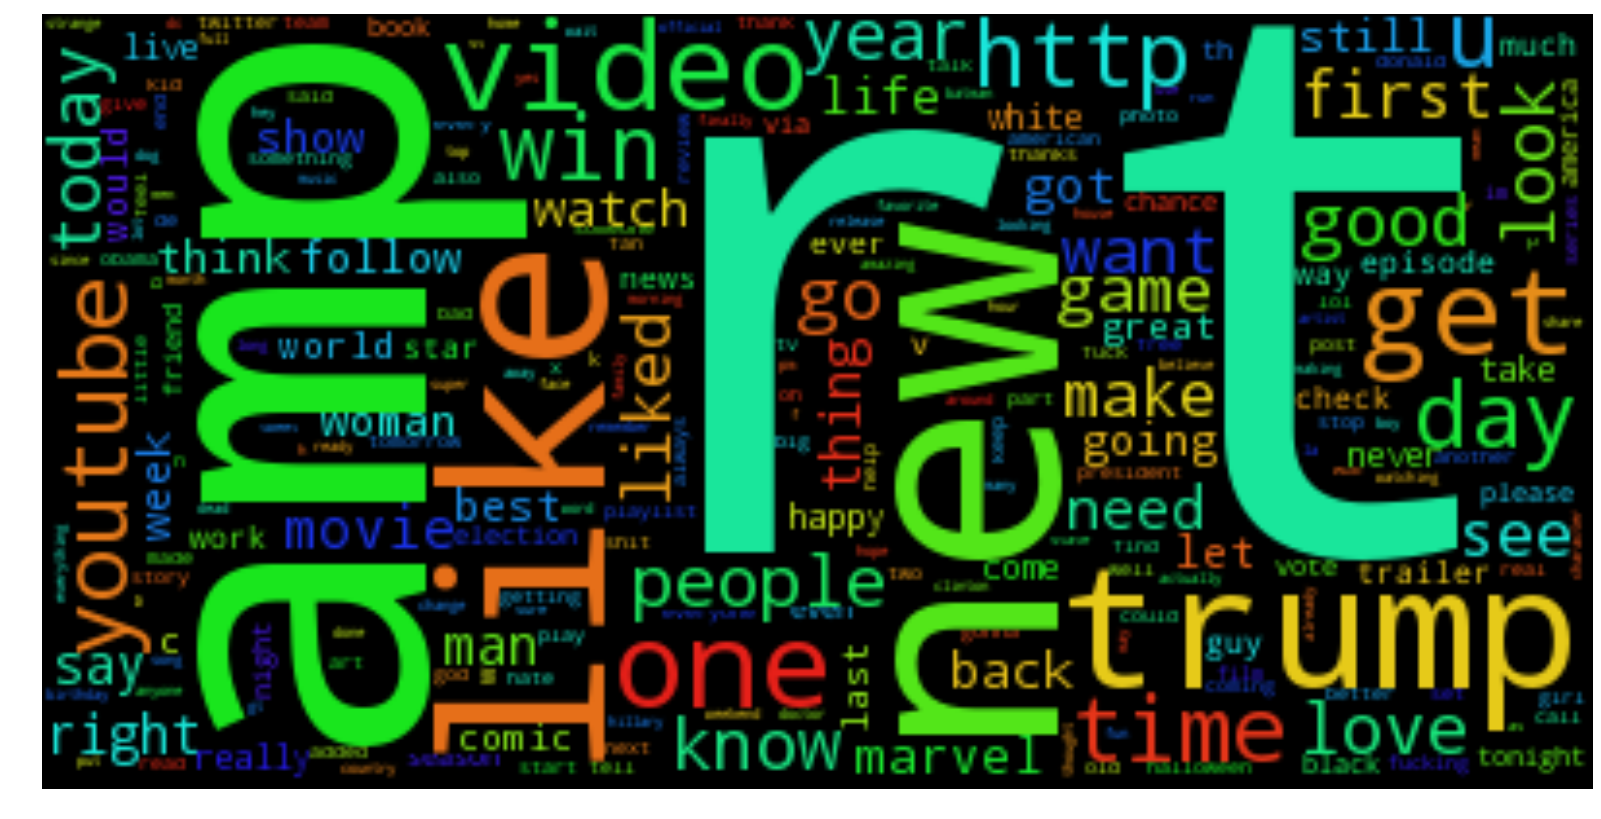

In [19]:
draw_tag_cloud(v, vs)